# Document visual question answering
This is a sample of using Document Visual Question Answering task of transformers.
Hugging Face provides extensive documentation on using Transformer models, including LayoutLM. 
This is a great starting point for understanding how to use the LayoutLM-Document-QA model.
https://huggingface.co/transformers/
https://huggingface.co/tasks/document-question-answering

This is a good tool for Extracting data from Documents with a Single Page! - Such as invoices, certificates or single page notices

In [1]:
from datasets import load_dataset
from PIL import Image

dataset = load_dataset("nielsr/funsd", split="train")
example = dataset[0]
words = example["words"]
boxes = example["bboxes"]
image = Image.open(example["image_path"])

In [2]:
from transformers import pipeline

nlp = pipeline(
    "document-question-answering",
    model="impira/layoutlm-invoices",
    framework = "pt", #torch
    # device=0  # use this for GPU, i want to use the CPU Only now 
)
# model="impira/layoutlm-document-qa"

Some weights of the model checkpoint at impira/layoutlm-invoices were not used when initializing LayoutLMForQuestionAnswering: ['token_classifier_head.weight', 'token_classifier_head.bias']
- This IS expected if you are initializing LayoutLMForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


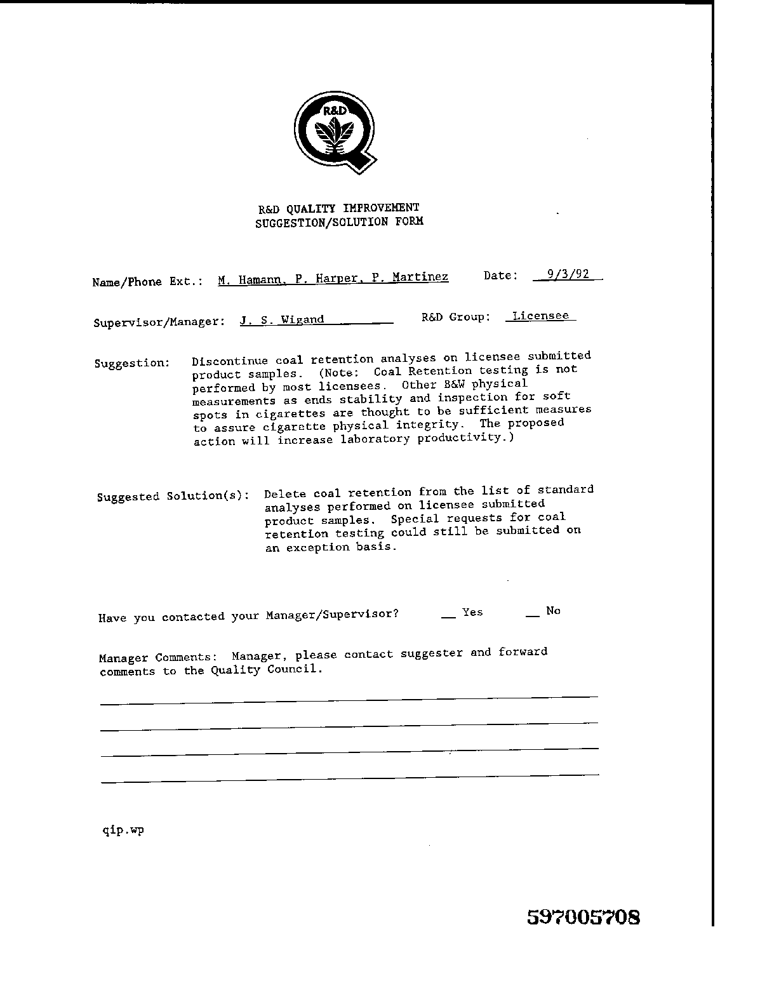

In [3]:
image

In [4]:
words_bbox = []
for word, bbox in zip(words,boxes):
    words_bbox.append([word,bbox])

In [5]:
prediction = nlp(
    image,
    "What is the advised solution?",  # Specify question here
    word_boxes = words_bbox
)

In [6]:
print(boxes[0])
for word, bbox in zip(words,boxes):
    print(word, bbox)

[383, 91, 493, 175]
R&D [383, 91, 493, 175]
: [287, 316, 295, 327]
Suggestion: [124, 355, 221, 370]
Date: [632, 268, 679, 282]
Licensee [670, 309, 748, 323]
Yes [604, 605, 633, 619]
No [715, 603, 738, 617]
597005708 [688, 904, 841, 926]
R&D [337, 203, 366, 214]
QUALITY [374, 203, 438, 216]
IMPROVEMENT [447, 201, 548, 211]
SUGGESTION/ [335, 215, 425, 229]
SOLUTION [434, 214, 507, 228]
FORM [518, 215, 555, 228]
Name [116, 274, 154, 289]
/ [153, 274, 166, 288]
Phone [167, 274, 213, 289]
Ext. [221, 272, 257, 287]
: [257, 274, 267, 288]
M. [282, 272, 301, 287]
Hamann [311, 272, 376, 286]
P. [384, 272, 402, 286]
Harper, [412, 274, 476, 285]
P. [485, 272, 503, 285]
Martinez [511, 271, 591, 282]
9/ [712, 265, 734, 279]
3/ [734, 264, 754, 279]
92 [754, 264, 774, 279]
R&D [551, 310, 580, 323]
Group: [587, 310, 644, 323]
J. [309, 313, 329, 327]
S. [335, 313, 358, 326]
Wigand [364, 313, 429, 327]
Supervisor [119, 316, 211, 330]
/ [213, 318, 221, 331]
Manager [221, 317, 286, 327]
Discontinue [249, 

In [7]:
prediction

[{'score': 0.019657494500279427,
  'answer': 'Discontinue coal retention analyses on licensee submitted product samples',
  'start': 36,
  'end': 44}]

### Now lets read a pdf

In [8]:
import fitz  # PyMuPDF
#import cv2
import numpy as np
from transformers import pipeline
from PIL import Image

In [31]:
pdf_document = "D:\\HWU\\F2Z7-ARI_201920.pdf" #this has multiple pages
pdf = fitz.open(pdf_document) 

In [32]:
page2 = pdf[1]

In [33]:
page2.get_text()

'F2Z7-ARI Master of Science in Artificial Intelligence \nPage | 2 of 5\n•\nResearch skills, and the capability of critical analysis, through review and analysis of current research \nliterature.\n•\nAn understanding of research ethics, and how to appropriately build on the work of others.\nLEARNING OUTCOMES – PERSONAL ABILITIES\nIndustrial, Commercial and Professional Practice\n•\nDemonstrate critical awareness of current legal, social, ethical and professional issues within the discipline.\n•\nMake informed judgements with incomplete or inconsistent data, or where there are no professional or ethical \ncodes or practices for guidance.\nAutonomy, Accountability and Working With Others\n•\nWork autonomously and within teams, as appropriate, demonstrating a capability for both taking and critically \nreflecting on roles and responsibilities.\nCommunication, Numeracy & Information and Communications Technology\n•\nDevelop and demonstrate skills and techniques in communication with peers a

In [35]:
pix = page2.get_pixmap()
image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

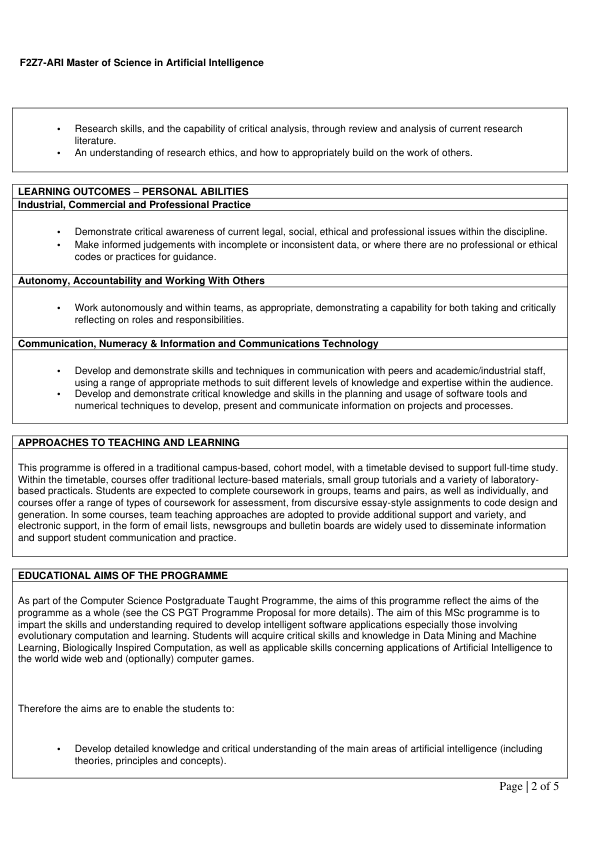

In [36]:
image

In [37]:
# Reference here: https://artifex.com/blog/text-extraction-with-pymupdf
#we use PyMuPDF to read this page
#we could have read the text, but we want to also show the PyMuPDF can read PDF 
# to image to help cover cases where CMAP is missing. 
# So we read the PDF as image and pass it on to the NLP pipeline and
# the pipeline then calls Tesseract OCR to extract text.
data = []
for page_number in range(len(pdf)):
    page = pdf[page_number]
    pix = page.get_pixmap()
    image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples) #PIL image
    page_data = {
         "page_number": page_number + 1,
          "image" : image # Store the image data
    }
    data.append(page_data)

pdf.close()



In [38]:
#uncomment below to check if we successfully read the image
#cv2.imshow('image',page_data["image"]) 
#cv2.waitKey(0)

In [39]:
#tell kernel where to look for the tesseract exe
import pytesseract
pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe' 

In [45]:
from transformers import pipeline

# Define the nlp pipeline with your LayoutLM model
nlp = pipeline(
    "document-question-answering",
    model="impira/layoutlm-invoices",
    framework="pt",  # Use PyTorch
    device=-1,  # Use CPU (set to -1 for CPU)
)

# Iterate through the data (each data represents a page)
for page_data in data:
    # Perform question-answering on the text content
    result = nlp(question="Educational aims of the program?", image = page_data["image"]  )
    print(result)
    # Extract the answer from the result
    #answer = result[0]["answer"]
    # Print or use the answer as needed
    #print("Answer:", answer)

Some weights of the model checkpoint at impira/layoutlm-invoices were not used when initializing LayoutLMForQuestionAnswering: ['token_classifier_head.weight', 'token_classifier_head.bias']
- This IS expected if you are initializing LayoutLMForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'score': 0.06416743993759155, 'answer': 'Computer', 'start': 17, 'end': 17}]
[{'score': 0.018978703767061234, 'answer': 'Computer Science', 'start': 301, 'end': 302}]
[{'score': 0.0006639238563366234, 'answer': 'Master', 'start': 1, 'end': 1}]
[{'score': 4.127706779399887e-05, 'answer': '‘8 taught courses (8 mandatory and 5 optional) plus a dissertation', 'start': 120, 'end': 130}]
[{'score': 0.2921871840953827, 'answer': 'Master of Science in Artfc', 'start': 1, 'end': 5}]


Not that perfect! I assume this might need additional training of the model on this kind of data

import fitz  # PyMuPDF
import cv2
import numpy as np

pdf_document = "your_document.pdf"  # Replace with the path to your PDF file
pdf = fitz.open(pdf_document)

data = []

for page_number in range(len(pdf)):
    page = pdf[page_number]
    page_data = {
        "page_number": page_number + 1,
        "width": page.rect.width,
        "height": page.rect.height,
        "word_boxes": [],  # Store word bounding boxes here
    }

    blocks = page.get_text("blocks")
    for block in blocks:
        x0, y0, x1, y1 = block[0:4]  # Coordinates of the text block
        text = block[4]  # Text content
        font_size = block[6]  # Font size
        page_data["word_boxes"].append({
            "x0": x0,
            "y0": y0,
            "x1": x1,
            "y1": y1,
            "text": text,
            "font_size": font_size,
        })

    # Convert the page to an image
    image = page.get_pixmap()
    image_data = np.frombuffer(image.samples, dtype=np.uint8).reshape(image.h, image.w, -1)
    
    # You can save the image if needed
    image_file = f"page_{page_number + 1}.png"
    cv2.imwrite(image_file, image_data)

    page_data["image"] = image_data  # Store the image data

    data.append(page_data)

pdf.close()
